In [1]:
from __future__ import print_function
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from scipy.stats import entropy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import math
import timeit

%matplotlib inline

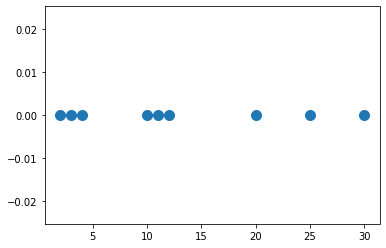

In [2]:
X = np.array([[2, 0], [3, 0], [4, 0], [10, 0], [11, 0],
             [12, 0], [20, 0], [25, 0], [30, 0]])
plt.scatter(X[:, 0], X[:, 1], s=100)
plt.show()

In [3]:
model1 = KMeans(n_clusters=2, init=np.array([[3,0],[4,0]]),\
                n_init=1, max_iter=1).fit(X)
    # n_init 여러번 돌려 그 중 가장 좋은 결과를 보여줌
    # 1차원이기에 1번만 함, 다차원일 경우 돌릴떄마다 결과가 다를 수 있어 사용
    # max_iter 최대반복횟수
c0, c1 = model1.cluster_centers_
c0, c1

(array([2.5, 0. ]), array([16.,  0.]))

In [4]:
model1.score(X)
    # 중심에 얼만큼 밀집되어 있는지 나오는 점보

-372.75

In [5]:
def kmeans_df(model, c0, c1):
    df = pd.DataFrame(np.hstack([X,
                                 np.linalg.norm(X-c0, axis=1)[:, np.newaxis],
                                 np.linalg.norm(X-c1, axis=1)[:, np.newaxis],
                                 model.labels_[:,np.newaxis]]),
                      columns=['x','y','거리1','거리2','번호'])
    return df

In [6]:
kmeans_df(model1,c0,c1)

,x,y,거리1,거리2,번호
0,2.0,0.0,0.5,14.0,0.0
1,3.0,0.0,0.5,13.0,0.0
2,4.0,0.0,1.5,12.0,0.0
3,10.0,0.0,7.5,6.0,1.0
4,11.0,0.0,8.5,5.0,1.0
5,12.0,0.0,9.5,4.0,1.0
6,20.0,0.0,17.5,4.0,1.0
7,25.0,0.0,22.5,9.0,1.0
8,30.0,0.0,27.5,14.0,1.0


In [7]:
def plot_cluster(model, c0, c1):
    plt.scatter(X[model.labels_ == 0, 0],
                X[model.labels_ == 0, 1],
                s=100, marker='v', c='r')
    plt.scatter(X[model.labels_ == 1, 0],
                X[model.labels_ == 1, 1],
                s=100, marker='^', c='b')
    plt.scatter(c0[0], c0[1], s=300, c='r')
    plt.scatter(c1[0], c1[1], s=300, c='b')
    plt.show()

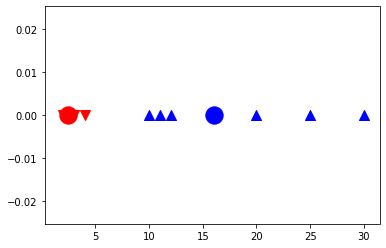

In [8]:
plot_cluster(model1, c0, c1)

In [9]:
# 2회차
model2 = KMeans(n_clusters=2, init=model1.cluster_centers_,\
                n_init=1, max_iter=1).fit(X)
c0, c1 = model2.cluster_centers_
c0, c1

(array([3., 0.]), array([18.,  0.]))

# 일반적인 방법

In [10]:
# 3회차
model = KMeans(n_clusters=2, init='random',
                n_init=10, max_iter=100).fit(X)
    # n_init 여러번 돌려 그 중 가장 좋은 결과를 보여줌
    # 1차원이기에 1번만 함, 다차원일 경우 돌릴떄마다 결과가 다를 수 있어 사용
    # max_iter 최대반복횟수
c0, c1 = model.cluster_centers_
c0, c1

(array([25.,  0.]), array([7., 0.]))

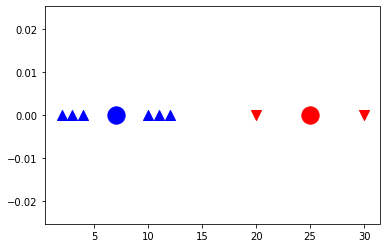

In [11]:
plot_cluster(model, c0, c1)
plt.show()

## 평가

### SSE

In [12]:
model.score(X)

-150.0

In [13]:
X[model.labels_,0]

array([3, 3, 3, 3, 3, 3, 2, 2, 2])

### seperation

In [14]:
def k_cohesion(model,c0,c1, X):
    total_mean = np.mean(X[:,0])
    m1=np.mean(X[model.labels_ == 0,0])
    m2=np.mean(X[model.labels_ == 1,0])
    count1 = np.count_nonzero(np.mean(X[model.labels_ ,0]==2))
    count2 = np.count_nonzero(np.mean(X[model.labels_ ,0]==3))
    separation = count1*(total_mean-m1)**2 + count2*(total_mean-m2)**2
    return separation

In [ ]:
k_cohesion(model, c0, c1, X)

### 유사도 matrix

In [16]:
def s_matrix(model,X):
    list1=[]
    list1.clear()
    for i in range(0, np.count_nonzero(X)):
        list1.append([])
        for j in range(0, np.count_nonzero(X)):
            if model.labels_[i]==model.labels_[j]:
                list1[i].append(1)
            else:
                list1[i].append(0)
    return list1

In [17]:
s_matrix(model,X)

[[1, 1, 1, 1, 1, 1, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 1, 1, 1]]

### entropy

In [18]:
def entropy(labels):
    '''computes entropy of 0-1 vector'''
    n_labels = len(labels)
    
    if n_labels <= 1:
        return 0
    
    counts = np.bincount(labels)
    probs = counts[np.nonzero(counts)] / n_labels
    n_classes = len(probs)
    
    if n_classes <=1:
        return 0
    return -np.sum(probs*np.log(probs)) / np.log(n_classes)

In [19]:
entropy(model.labels_)

0.9182958340544894

## 좋은 K를 찾는 방법
SSE지표를 활용

In [20]:
ks = range(1,10)
intertias = [] #SSE

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X)
    intertias.append(model.inertia_) # model.inertia_ : 양수의 SSE

intertias

[798.0, 150.0, 54.0, 16.5, 4.0, 2.5, 1.0, 0.5, 0.0]

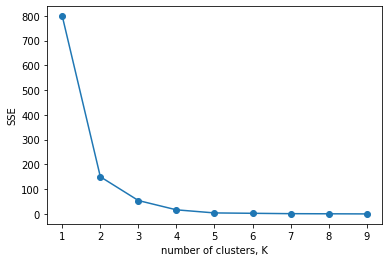

In [21]:
plt.plot(ks,intertias,'-o')
plt.xlabel('number of clusters, K')
plt.ylabel('SSE')
plt.xticks(ks)
plt.show()

# 2차원 데이터

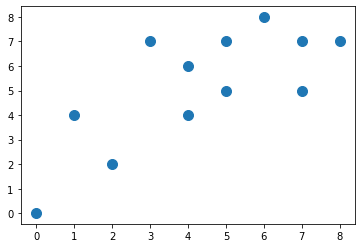

In [30]:
X = np.array([[7, 5], [5, 7], [7, 7], [4, 4], [4, 6], [1, 4],
              [0, 0], [2, 2], [8, 7], [6, 8], [5, 5], [3, 7]])
plt.scatter(X[:, 0], X[:, 1], s=100)
plt.show()

In [31]:
ks = range(1,10)
intertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X)
    intertias.append(model.inertia_)

intertias

[130.33333333333334,
 45.77777777777777,
 26.35,
 19.5,
 12.916666666666666,
 9.666666666666666,
 6.333333333333333,
 4.166666666666667,
 2.5]

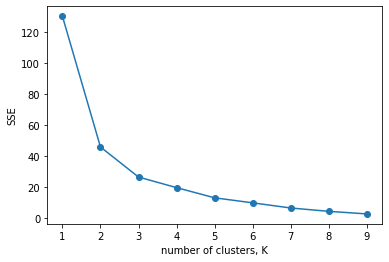

In [32]:
plt.plot(ks,intertias,'-o')
plt.xlabel('number of clusters, K')
plt.ylabel('SSE')
plt.xticks(ks)
plt.show()

In [33]:
model3 = KMeans(n_clusters=2, init='random', random_state=1,
                n_init=10, max_iter=100).fit(X)
print(model3.cluster_centers_)

[[1.         2.        ]
 [5.44444444 6.22222222]]


In [38]:
entropy(model3.labels_)

0.8112781244591328

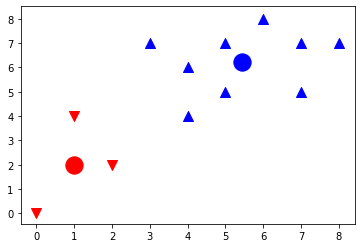

In [37]:
c0, c1 = model3.cluster_centers_
plot_cluster(model3, c0, c1)
plt.show()

In [28]:
model4 = KMeans(n_clusters=3, init='random', random_state=1,
                n_init=10, max_iter=100).fit(X)
print(model4.cluster_centers_)

[[7.   6.75]
 [4.2  5.8 ]
 [1.   2.  ]]


In [39]:
entropy(model4.labels_)

0.9808340377961402